In [1]:
import os

# Set environment variables to disable multithreading as users will probably
# want to set the number of cores to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
###############################################################################
# Set TensorFlow print of log information
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [5]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from anomaly.constants import GALAXY_LINES
from autoencoders.ae import AutoEncoder
from sdss.metadata import MetaData
from sdss.utils.managefiles import FileDirectory
from anomaly.utils import specobjid_to_idx
from anomaly.utils import set_intersection
from astroExplain.spectra.utils import get_anomaly_score_name
from astroExplain.spectra.notebook import explanation_name
from astroExplain.spectra.notebook import interpret
from astroExplain.spectra.notebook import explain_reconstruction_score

meta = MetaData()
%matplotlib inline

In [7]:
# config
bin_id = "bin_04"
model_id = "0013"
architecture = "256_128_64/latent_12"
meta_data_directory = "/home/edgar/spectra/0_01_z_0_5_4_0_snr_inf"
model_directory = f"{meta_data_directory}/{bin_id}/models/{architecture}/{model_id}"
explanations_directory = f"{meta_data_directory}/{bin_id}/explanation/{architecture}"
scores_directory = f"{meta_data_directory}/bin_04/explanation/256_128_64/latent_12"

In [4]:
# load data
wave = np.load(f"{meta_data_directory}/wave.npy")
meta_data_df = pd.read_csv(f"{meta_data_directory}/0_01_z_0_5_4_0_snr_inf.csv.gz", index_col="specobjid")
model = AutoEncoder(reload=True, reload_from=model_directory)
spectra = np.load(f"{meta_data_directory}/spectra.npy", mmap_mode="r")
idx_id = np.load(f"{meta_data_directory}/{bin_id}/{bin_id}_index_specobjid.npy")

### Get common anomalies
The common anomalies are selected for the mse, mse with filter, $\chi^2$ and $\chi^2$ with filter

In [97]:
scores_names = [
    "mse_noRel100", "mse_filter_250kms_noRel100",
    "mse_rel100", "mse_filter_250kms_rel100",
    # "mse_noRel97", "mse_filter_250kms_noRel97",
    # "mse_rel97", "mse_filter_250kms_rel97",    
]

scores_specobjid = {}

for score_name in scores_names:
    
    specobjids = pd.read_csv(
        f"{scores_directory}/{score_name}/top_anomalies.csv.gz",
        index_col="specobjid",
    ).index
        
    scores_specobjid[score_name] = specobjids

In [101]:
intersections = set_intersection(scores_specobjid, 1000, 99)
intersections = list(intersections)
len(intersections)

273

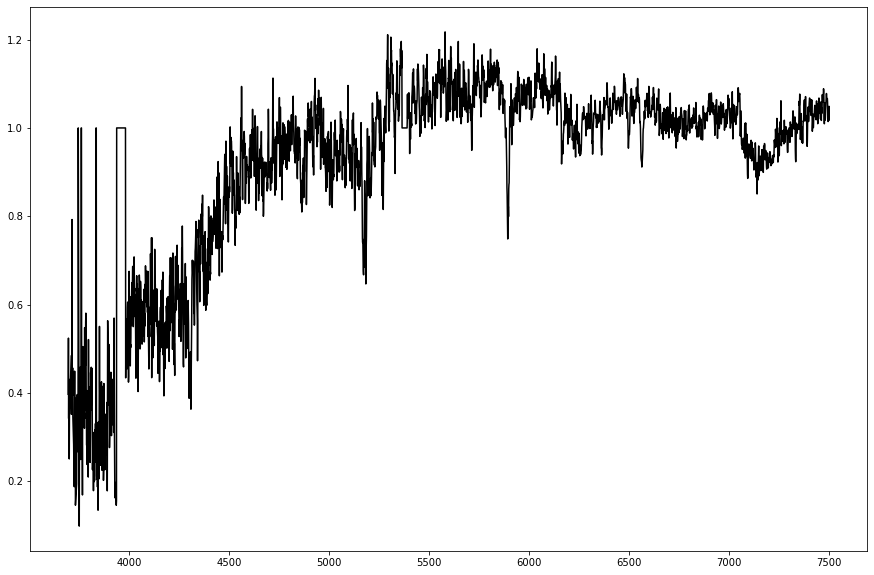

In [102]:
# save_to = "/home/edgar/Downloads/tata"

# fig, ax = plt.subplots(figsize=(15, 10))

# for specobjid in intersections:
#     ax.clear()
#     idx_spectrum = specobjid_to_idx(specobjid=specobjid, ids=idx_id)
#     spectrum = spectra[idx_spectrum]
#     ax.plot(wave, spectrum, color="black")

#     fig.savefig(f"{save_to}/{specobjid}.jpg")

In [ ]:
interesting = [308548283616225280, 308571098482501632, 308571098482501632, 332235063821363200, 369471129590458368, 378466779225155584, 417825723412146176, 440372303885264896, 635057062795044864, 745490635007485952, 1119282266950887424, 1415340070054946816, 1432320103755573248, 1593224832642738176, 1780176998165932032, 1780176998165932032, 2193347358492747776, 2361062465875240960, 2435337505558521856, 2974795850158467072
]
# 1119282266950887424 super blue object
# 2361062465875240960 braod and red and high ionization
# 2435337505558521856 really broad

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=308571098482501632&apid=


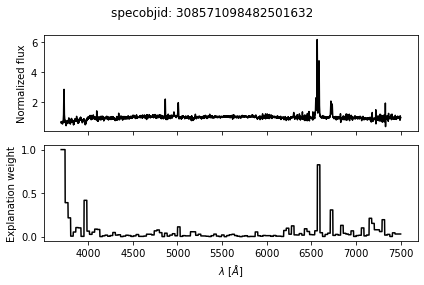

In [106]:
specobjid = 308571098482501632
idx_spectrum = specobjid_to_idx(specobjid=specobjid, ids=idx_id)
spectrum = spectra[idx_spectrum]

# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
# if reconstruction
    "relative": True,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 128,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0
}
explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=None)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

# save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
# FileDirectory.check_directory(save_to, exit_program=False)
# explanation_Str = explanation_name(lime_config, fudge_config)

# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )